#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# First Steps with TensorFlow 2.x

This notebook is modified from `first_steps_with_tensorflow.ipynb` to use Tensorflow 2.x instead of Tensorflow 1.x.

**Learning Objectives:**
  * Learn fundamental TensorFlow 2.x concepts
  * Create a multi-layer perceptron model in TensorFlow to predict median housing price, at the granularity of city blocks, based on nine numerical features.
  * Evaluate the accuracy of a model's predictions using Root Mean Squared Error (RMSE)
  * Convert the model to run on static graph for better performance

The [data](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) is based on 1990 census data from California.

## Setup
In this first cell, we'll load the necessary libraries.

In [1]:
# #uncomment if you're running from colab
# %tensorflow_version 2.x

from IPython import display
import math
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.layers import Layer
print(tf.__version__)

2.0.0-beta1


Next, we'll load our data set.

In [2]:
cali_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
# cali_df = pd.read_csv('data/california_housing_train.csv', sep=",")

We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we'll scale `median_house_value` to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [3]:
cali_df = cali_df.reindex(
    np.random.permutation(cali_df.index))
cali_df["median_house_value"] /= 1000.0
cali_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
11076,-120.99,39.26,16.0,2616.0,422.0,1090.0,425.0,3.7917,179.200
14701,-122.18,37.41,21.0,1034.0,117.0,323.0,117.0,10.7237,500.001
6422,-118.26,33.83,28.0,4112.0,861.0,3211.0,841.0,4.4539,192.200
13159,-121.89,37.34,20.0,1106.0,494.0,851.0,448.0,0.8894,350.000
8620,-118.53,34.21,18.0,3124.0,796.0,1855.0,725.0,2.9389,213.200


## Examine the Data

It's a good idea to get to know your data a little bit before you work with it.

We'll print out a quick summary of a few useful statistics on each column: count of examples, mean, standard deviation, max, min, and various quantiles.

In [4]:
cali_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207.300912
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115.983764
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14.999000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119.400000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180.400000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500.001000


## Build the First Model

In this exercise, we'll try to predict `median_house_value`, which will be our label (sometimes also called a target). We'll use every other numerical features as our input feature.

**NOTE:** Our data is at the city block level, so this feature represents the total number of rooms in that block.

To train our model, we'll use a multi-layer perceptron (MLP) model based on Tensorflow 2.x `tf.keras` APIs and Eager Mode. We will then convert the model to static graph mode for better performance.

### Step 1: Define Features and Target

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. There are two main types of data we'll use in this and future exercises:

* **Categorical Data**: Data that is textual. In this exercise, our housing data set does not contain any categorical features, but examples you might see would be the home style, the words in a real-estate ad.

* **Numerical Data**: Data that is a number (integer or float) and that you want to treat as a number. As we will discuss more later sometimes you might want to treat numerical data (e.g., a postal code) as if it were categorical.

In TensorFlow, we indicate a feature's data type using a construct called a **feature column**. Feature columns store only a description of the feature data; they do not contain the feature data itself.

To start, we're going to use just numerical features and median household value as target.

In [5]:
num_features = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income']
target = ['median_house_value']

#split
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(cali_df[num_features+target],test_size=0.2)
train_df.shape, valid_df.shape

((13600, 9), (3400, 9))

In [8]:
#standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_df[num_features])
train_scaled = scaler.transform(train_df[num_features])
valid_scaled = scaler.transform(valid_df[num_features])
train_scaled.mean(1), train_scaled.std(1), valid_scaled.mean(1), valid_scaled.std(1)

(array([-0.01589618, -0.20802771, -0.15837125, ..., -0.22034211,
        -0.17528519,  0.23055533]),
 array([1.0240923 , 1.45924124, 0.70915697, ..., 0.74074247, 0.64516871,
        0.66589931]),
 array([-0.09096787,  0.44995171, -0.28523095, ..., -0.16459333,
        -0.03167588, -0.01149345]),
 array([0.64318357, 0.89706566, 0.65308995, ..., 0.43029873, 0.53044619,
        0.80643883]))

In [9]:
#to numpy
train_x = np.array(train_scaled)
train_y = np.array(train_df[target])
valid_x = np.array(valid_scaled)
valid_y = np.array(valid_df[target])
train_x.shape,train_y.shape,valid_x.shape,valid_y.shape

((13600, 8), (13600, 1), (3400, 8), (3400, 1))

In [10]:
train_x[:10],train_y[:10]

(array([[ 2.03485894, -1.38364979, -0.29298431, -0.14779587,  0.0763758 ,
          0.64742097,  0.25703771, -1.31843288],
        [-2.2928836 ,  2.41990585,  1.85046161, -0.62783383, -0.6211932 ,
         -0.72243643, -0.56402007, -1.10622204],
        [ 1.25616478, -1.34617634,  0.50088455, -0.2285584 , -0.35960482,
         -0.3683704 , -0.30840774, -0.41290163],
        [ 1.19626523, -1.33212379,  1.05659275, -0.70042937, -0.55520694,
         -0.46376198, -0.60016727, -0.84332927],
        [ 1.17130709, -1.14007234, -1.00746628,  0.1616426 ,  0.27197792,
          0.44374706,  0.26736549, -0.61936992],
        [-0.85030275,  1.1692293 ,  0.65965832, -0.18863085, -0.08623319,
          0.02007097, -0.08119678, -0.6948133 ],
        [ 0.54735343, -0.74191688,  0.26272389,  0.118539  ,  0.4887899 ,
         -0.10453965,  0.52555976,  0.33636911],
        [ 0.75201023, -0.76533779,  0.73904521, -0.81023011, -0.85450175,
         -0.81439047, -0.84286989,  0.26208478],
        [ 1.3010

### Step 2: Create `Dataset` Object

`Dataset` object is responsible for shuffling and feeding the features-target pairs into the architecture. We also create a validation `Dataset` with batch size equal to all validation examples and no shuffling.

In [11]:
#datasets
#shuffle with buffer equal to size of dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_x,train_y))\
  .shuffle(buffer_size=train_y.shape[0]).batch(64)
#no shuffling for validation
valid_ds = tf.data.Dataset.from_tensor_slices((train_x,train_y))\
  .batch(valid_y.shape[0])
train_ds, valid_ds

(<BatchDataset shapes: ((None, 8), (None, 1)), types: (tf.float64, tf.float64)>,
 <BatchDataset shapes: ((None, 8), (None, 1)), types: (tf.float64, tf.float64)>)

## Step 3: Define Architecture

There are several ways to define an architecture in Tensorflow 2.0. Here we introduce:

#### Step 3.1: `tf.keras.layers.Layer` 

You can create your own `tf.keras.layers.Layer` object, which acts as a layer or a collection of layers in your architecture. Here we define our own `Linear` layer for a fully-connect layer instead of using `tf.keras.layers.Dense`.

In [12]:
class Linear(Layer):
    def __init__(self, output_dim):
        super(Linear,self).__init__()
        self.output_dim = output_dim
    #use build method to build the weights without having to specify input dimension
    def build(self,x_shape):
        self.w = self.add_weight(shape=(x_shape[-1],self.output_dim),
                                initializer='he_normal',trainable=True)
        self.b = self.add_weight(shape=(self.output_dim,),
                                initializer='zeros',trainable=True)
    def call(self,x):
        return tf.matmul(x,self.w) + self.b

In [13]:
#piece linear layers together to get our simple MLP architecture
class MLP(Layer):
    def __init__(self,output_dims=[32,32,1]):
        super(MLP,self).__init__()
        #we intentionally do not specify any activation to show we can use functional tf.nn later
        self.linears = [Linear(i) for i in output_dims]
#         #we can also use the predefined tf.keras.layers.Dense; we can also specify activations
#         self.linears = [tf.keras.layers.Dense(i,activation='relu') for i in output_dims]
    def call(self,x):
        for l in self.linears[:-1]:
            x = tf.nn.relu(l(x))
        return self.linears[-1](x)

In [14]:
m = MLP([32,32,1])
x = tf.random.normal((64,9))
m(x).shape

TensorShape([64, 1])

#### Step 3.2: `tf.keras.Sequential`

`tf.keras.Sequential` will create a model but do not build it unless you specify the input shape.

In [15]:
#without input shape
m = tf.keras.Sequential()
for i in [32,32]:
    m.add(tf.keras.layers.Dense(i,activation='relu'))
m.add(tf.keras.layers.Dense(1))
m.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [16]:
#with input shape
m = tf.keras.Sequential()
m.add(tf.keras.layers.Dense(32,activation='relu',input_dim=9))
m.add(tf.keras.layers.Dense(32,activation='relu'))
m.add(tf.keras.layers.Dense(1))
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


### Step 4: Define Loss

We need to specify which loss function to optimize for. In our case, we use a simple mean squared error loss (MSE loss).

In [17]:
loss_fn = tf.keras.losses.MeanSquaredError()
y = tf.ones((10,1))
preds = tf.random.uniform((10,1))
print(f'y: {y.shape}, preds: {preds.shape}, MSE Loss: {loss_fn(y,preds)}')
print(f'MSE Loss by hand: {((y.numpy()-preds.numpy())**2).mean()}')

y: (10, 1), preds: (10, 1), MSE Loss: 0.41295117139816284
MSE Loss by hand: 0.41295117139816284


### Step 5: Define Optimizer

Last step of preparation is to define which optimizer to apply the gradients.

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3,
                                    beta_1=0.9, beta_2=0.999)

### Step 6: Training Loop

We put what we have prepared so far together: datasets, architecture, loss function, and optimizer to train the model.

In [66]:
#datasets
#shuffle with buffer equal to size of dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_x,train_y))\
  .shuffle(buffer_size=train_y.shape[0]).batch(64)
#no shuffling for validation
valid_ds = tf.data.Dataset.from_tensor_slices((train_x,train_y))\
  .batch(valid_y.shape[0])
train_ds, valid_ds

#architecture
class MLP(Layer):
    def __init__(self,output_dims=[64,32,1]):
        super(MLP,self).__init__()
        #we can also use the predefined tf.keras.layers.Dense; we can also specify activations
        self.linears = [tf.keras.layers.Dense(i,activation='relu') for i in output_dims]
    def call(self,x):
        for l in self.linears[:-1]: x = l(x)
        return self.linears[-1](x)
m = MLP([32,32,1])

#loss fn
loss_fn = tf.keras.losses.MeanSquaredError()

#optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-3,
                                    beta_1=0.9, beta_2=0.999)

As we train the model in Eager Mode, we use `tf.GradientTape()` to record the gradients and use our optimizer to apply them. Let's say we train for 10 epochs (10 rounds of all data).

In [67]:
from datetime import datetime
start_time = datetime.now()

#to log epoch-level train and validation losses
epoch_train_losses = []
epoch_valid_losses = []
for e in range(10):
    #training loop
    for i,(x,y) in enumerate(train_ds):
        epoch_train_loss = []
        with tf.GradientTape() as tape:
            preds = m(x) #prediction
            train_loss = loss_fn(y,preds) #record loss
            epoch_train_loss.append(train_loss)
            #record gradients
            gradients = tape.gradient(train_loss,m.trainable_weights)
        #update 
        optimizer.apply_gradients(zip(gradients,m.trainable_weights))
    epoch_train_losses.append(np.mean(epoch_train_loss))
    
    #validation loop
    for i,(x,y) in enumerate(valid_ds):
        epoch_valid_loss = []
        preds = m(x) #prediction
        valid_loss = loss_fn(y,preds) #record loss
        epoch_valid_loss.append(valid_loss)
        # do not record or apply gradients
    epoch_valid_losses.append(np.mean(epoch_valid_loss))
    
    #log
    print(f'epoch {e} - Train Loss: {np.mean(epoch_train_loss)}; Valid Loss: {np.mean(epoch_valid_loss)}')

print(f'Done in {datetime.now()-start_time}')

epoch 0 - Train Loss: 14785.23828125; Valid Loss: 11783.486328125
epoch 1 - Train Loss: 8391.20703125; Valid Loss: 6303.48388671875
epoch 2 - Train Loss: 6749.06298828125; Valid Loss: 4983.7705078125
epoch 3 - Train Loss: 6067.9052734375; Valid Loss: 4369.4609375
epoch 4 - Train Loss: 5717.25390625; Valid Loss: 4067.29052734375
epoch 5 - Train Loss: 5602.755859375; Valid Loss: 3917.6123046875
epoch 6 - Train Loss: 5545.703125; Valid Loss: 3834.904296875
epoch 7 - Train Loss: 5488.9423828125; Valid Loss: 3774.08740234375
epoch 8 - Train Loss: 5377.0; Valid Loss: 3726.438232421875
epoch 9 - Train Loss: 5273.7060546875; Valid Loss: 3682.73828125
Done in 0:00:12.966611


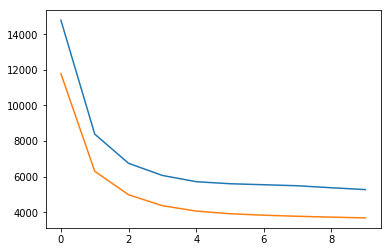

In [68]:
#plot losses by epoch
plt.plot(epoch_train_losses)
plt.plot(epoch_valid_losses)

### Step 7: Evaluate the Model

Is this a good model? How would you judge how large this error is?

Mean Squared Error (MSE) can be hard to interpret, so we often look at Root Mean Squared Error (RMSE)
instead.  A nice property of RMSE is that it can be interpreted on the same scale as the original targets.

Let's compare the RMSE to the difference of the min and max of our targets:

In [69]:
root_mean_squared_error = np.sqrt(epoch_valid_losses[-1])

min_house_value = cali_df["median_house_value"].min()
max_house_value = cali_df["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 60.686


#### Is There a Standard Heuristic for Model Tuning?

This is a commonly asked question. The short answer is that the effects of different hyperparameters are data dependent. So there are no hard-and-fast rules; you'll need to test on your data.

That said, here are a few rules of thumb that may help guide you:

 * Training error should steadily decrease, steeply at first, and should eventually plateau as training converges.
 * If the training has not converged, try running it for longer.
 * If the training error decreases too slowly, increasing the learning rate may help it decrease faster.
   * But sometimes the exact opposite may happen if the learning rate is too high.
 * If the training error varies wildly, try decreasing the learning rate.
   * Lower learning rate plus larger number of steps or larger batch size is often a good combination.
 * Very small batch sizes can also cause instability.  First try larger values like 100 or 1000, and decrease until you see degradation.

Again, never go strictly by these rules of thumb, because the effects are data dependent.  Always experiment and verify.

### Step 8: Convert to Static Graph

Eager Mode is on by default for Tensorflow 2.0 but we can also convert our models to static graph to enjoy the performance edge it offers after we completed the debugging in the more friendly Eager Mode by using the `@tf.function` decorator. This shrinks our time to run 10 epochs from 12 to 2 seconds!

In [73]:
#datasets
#shuffle with buffer equal to size of dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_x,train_y))\
  .shuffle(buffer_size=train_y.shape[0]).batch(64)
#no shuffling for validation
valid_ds = tf.data.Dataset.from_tensor_slices((train_x,train_y))\
  .batch(valid_y.shape[0])
train_ds, valid_ds

#architecture
class MLP(Layer):
    def __init__(self,output_dims=[64,32,1]):
        super(MLP,self).__init__()
        #we can also use the predefined tf.keras.layers.Dense; we can also specify activations
        self.linears = [tf.keras.layers.Dense(i,activation='relu') for i in output_dims]
    def call(self,x):
        for l in self.linears[:-1]: x = l(x)
        return self.linears[-1](x)
m = MLP([32,32,1])

#loss fn
loss_fn = tf.keras.losses.MeanSquaredError()

#optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-3,
                                    beta_1=0.9, beta_2=0.999)

In [76]:
@tf.function
def train_batch(x,y):
    with tf.GradientTape() as tape:
        preds = m(x) #prediction
        train_loss = loss_fn(y,preds) #record loss
        gradients = tape.gradient(train_loss,m.trainable_weights)
    optimizer.apply_gradients(zip(gradients,m.trainable_weights))
    return train_loss

@tf.function
def valid_batch(x,y):
    preds = m(x) #prediction
    valid_loss = loss_fn(y,preds) #record loss
    return valid_loss

In [77]:
from datetime import datetime
start_time = datetime.now()

#to log epoch-level train and validation losses
epoch_train_losses = []
epoch_valid_losses = []
for e in range(10):
    #training loop
    for i,(x,y) in enumerate(train_ds):
        epoch_train_loss = []
        train_loss = train_batch(x,y)
        epoch_train_loss.append(train_loss)
    epoch_train_losses.append(np.mean(epoch_train_loss))
    
    #validation loop
    for i,(x,y) in enumerate(valid_ds):
        epoch_valid_loss = []
        valid_loss = valid_batch(x,y)
        epoch_valid_loss.append(valid_loss)
        # do not record or apply gradients
    epoch_valid_losses.append(np.mean(epoch_valid_loss))
    
    #log
    print(f'epoch {e} - Train Loss: {np.mean(epoch_train_loss)}; Valid Loss: {np.mean(epoch_valid_loss)}')

print(f'Done in {datetime.now()-start_time}')

epoch 0 - Train Loss: 7815.93212890625; Valid Loss: 3844.982421875
epoch 1 - Train Loss: 7698.8271484375; Valid Loss: 3813.7626953125
epoch 2 - Train Loss: 7590.92431640625; Valid Loss: 3781.134033203125
epoch 3 - Train Loss: 7483.203125; Valid Loss: 3746.886962890625
epoch 4 - Train Loss: 7384.595703125; Valid Loss: 3712.256103515625
epoch 5 - Train Loss: 7266.416015625; Valid Loss: 3679.6982421875
epoch 6 - Train Loss: 7188.17041015625; Valid Loss: 3648.277587890625
epoch 7 - Train Loss: 7126.32421875; Valid Loss: 3617.36767578125
epoch 8 - Train Loss: 7081.24658203125; Valid Loss: 3585.864013671875
epoch 9 - Train Loss: 7041.9091796875; Valid Loss: 3551.591064453125
Done in 0:00:02.424246
